# The Hotel Bookings Data
Let’s use hotel bookings data from [Antonio, Almeida, and Nunes (2019)](https://www.sciencedirect.com/science/article/pii/S2352340918315191?via%3Dihub) to predict which hotel stays included children and/or babies, based on the other characteristics of the stays such as which hotel the guests stay at, how much they pay, etc.

<img src="https://s3-us-west-2.amazonaws.com/fligoo.data-science/TechInterviews/HotelBookings/header.png"/>

One of the hotels (H1) is a resort hotel and the other is a city hotel (H2). Both datasets share the same structure, with 23 variables describing the 19248 observations of H1 and 30752 observations of H2. Each observation represents a hotel booking. Both datasets comprehend bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017, including bookings that effectively arrived and bookings that were canceled. Since this is hotel real data, all data elements pertaining hotel or custumer identification were deleted.

**Goals**
- During **Part I**, you should perform an Exploratory Data Analysis highlighting key findings:
  - Data Quality Check: You must check the quality of the given dataset to make an assessment of how appropriate it is for later Data Science tasks. Propose a set of corrective actions over the data if any.
  - Report insights and conclusions: Describe the results obtained during the exploratory analysis and provide conclusions from a business perspective, supported by plots / tables / metrics.
- In **Part II** you should define and train a model to predict which actual hotel stays included children/babies, and which did not:
  - Feature extraction: Indicate some possible candidates of features that could properly describe the hotels, either from the given columns or from their transformations.
  - Machine Learning modeling: at least one fitted model with the given data. You could use the `children` column as target.
- Finally, on **Part III** you should present the key findings, conclusions and results to non-technical stakeholders.
  

## Part I - Exploratory Data Analisys

Import libraries

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

Load dataset

In [2]:
hotels = pd.read_csv('https://s3-us-west-2.amazonaws.com/fligoo.data-science/TechInterviews/HotelBookings/hotels.csv')

Exploratory data analysis

In [3]:
hotels.head()

,hotel,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,country,market_segment,distribution_channel,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces,total_of_special_requests,arrival_date
0,City_Hotel,217,1,3,2,none,BB,DEU,Offline_TA/TO,TA/TO,...,A,A,0,No_Deposit,0,Transient-Party,80.75,none,1,2016-09-01
1,City_Hotel,2,0,1,2,none,BB,PRT,Direct,Direct,...,D,K,0,No_Deposit,0,Transient,170.00,none,3,2017-08-25
2,Resort_Hotel,95,2,5,2,none,BB,GBR,Online_TA,TA/TO,...,A,A,2,No_Deposit,0,Transient,8.00,none,2,2016-11-19
3,Resort_Hotel,143,2,6,2,none,HB,ROU,Online_TA,TA/TO,...,A,A,0,No_Deposit,0,Transient,81.00,none,1,2016-04-26
4,Resort_Hotel,136,1,4,2,none,HB,PRT,Direct,Direct,...,F,F,0,No_Deposit,0,Transient,157.60,none,4,2016-12-28


In [4]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           50000 non-null  object 
 1   lead_time                       50000 non-null  int64  
 2   stays_in_weekend_nights         50000 non-null  int64  
 3   stays_in_week_nights            50000 non-null  int64  
 4   adults                          50000 non-null  int64  
 5   children                        50000 non-null  object 
 6   meal                            50000 non-null  object 
 7   country                         49711 non-null  object 
 8   market_segment                  50000 non-null  object 
 9   distribution_channel            50000 non-null  object 
 10  is_repeated_guest               50000 non-null  int64  
 11  previous_cancellations          50000 non-null  int64  
 12  previous_bookings_not_canceled  

Duplicates

First, I'll remove the duplicated records to avoid misleading information during the EDA.

In [5]:
hotels_copy=hotels.copy()

In [6]:
hotels_copy=hotels_copy.drop_duplicates().reset_index(drop=True) #reset index of the duplicate-free copy
hotels_copy.shape[0]

43385

Null values

Next, let's see the amount of null values in a graphical way

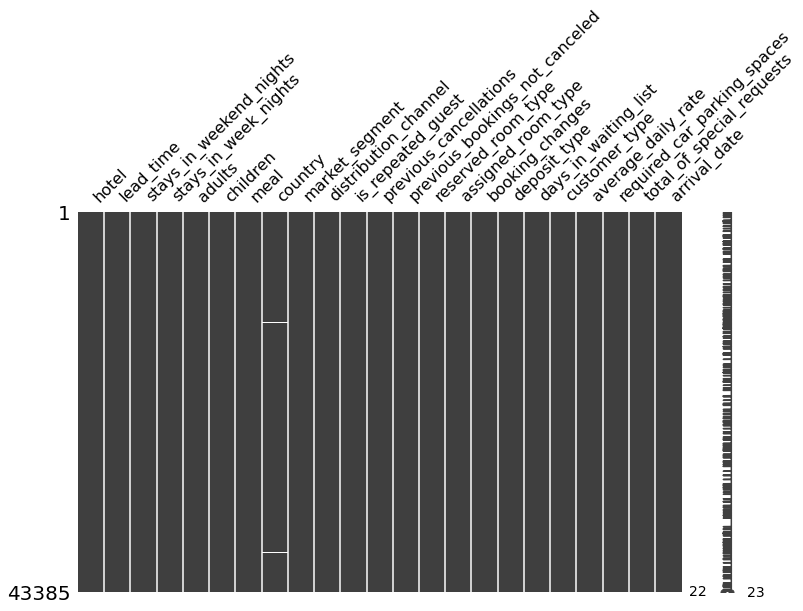

In [7]:
msno.matrix(hotels_copy, figsize=(12, 7))

The dataset is almost complete, except for the country column. I'll see later how can I input these records or if it's best to drop them.

Now, let's analyze some features of the dataset to better understand the behaviour of the people that stays in both hotels H1 and H2.



**Categorical features**

In [8]:
#Select categorical columns to plot
cat_cols_to_plot=['hotel', 'distribution_channel', 'market_segment','reserved_room_type', 'assigned_room_type', 'meal', 'is_repeated_guest', 'deposit_type', 'customer_type']

I'll define a function that plots the categorical data in a countplot using the target variable as the color coding.

In [9]:
def multiple_countplots(width, high, df, list_of_cols, color_code):
  fig=plt.figure(figsize= (width, high))
  for i, var_name in enumerate(list_of_cols):
    ax=fig.add_subplot(len(list_of_cols), 1, i+1)
    sns.countplot(data=df, x=var_name, axes=ax, hue=color_code)
    ax.set_title(var_name)
  fig.tight_layout()
  plt.show()

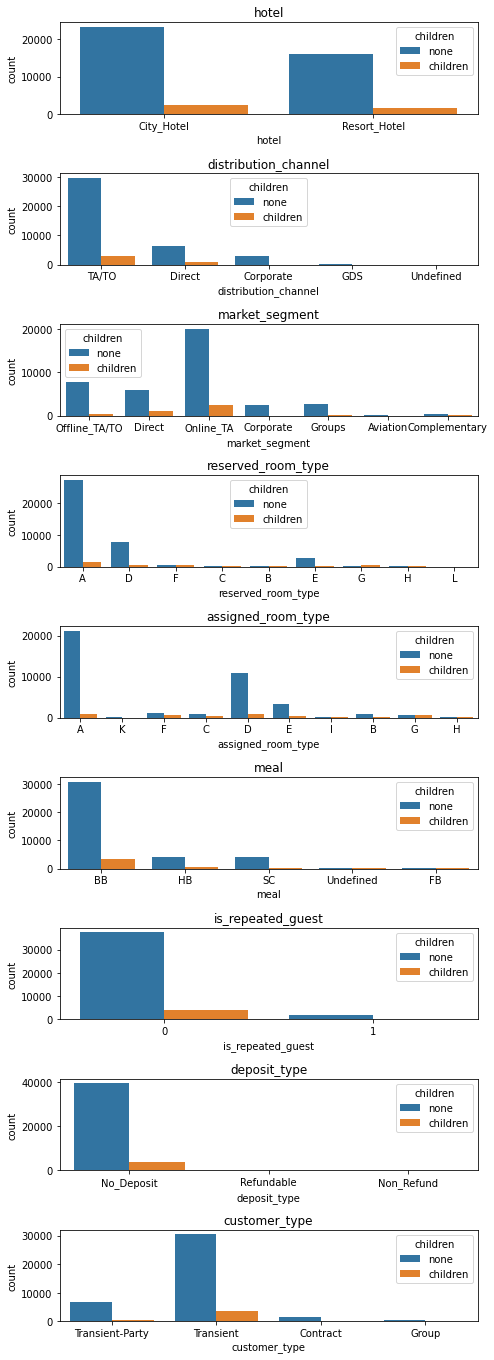

In [10]:
multiple_countplots(7, 19, hotels_copy, cat_cols_to_plot, 'children')

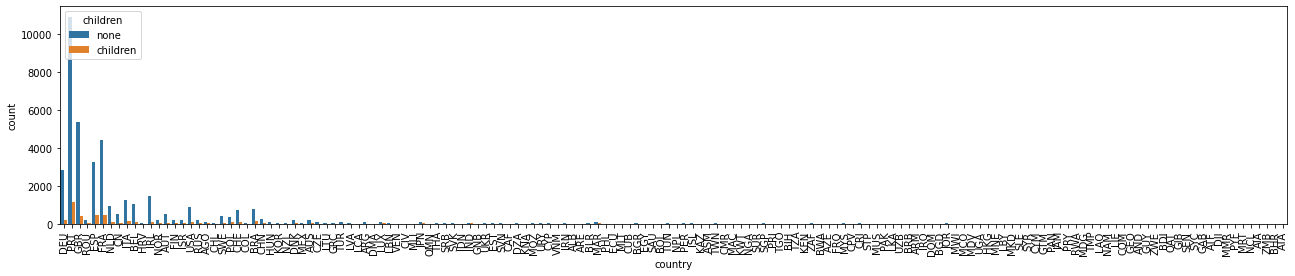

In [11]:
fig=plt.figure(figsize= (22, 4))
sns.countplot(data=hotels_copy, x='country', hue='children')
plt.xticks(rotation=90)
plt.show()

From this first couple of plots, I can see that the dataset is imbalanced since it doesn't contain many records for people with children.

At the same time, I can observe that majority of people:
* Stay at the City Hotel
* Book rooms type A
* Book rooms by travel agents (TA) or tour operators (TO)
* Are not frequent guests of the hotels
* Don't make a deposit (it can be a good idea to drop this column since it doesn't bring useful information for our classifier)
* Have reservations that aren't part of a group or contract (Transient customer type)
* Book the rooms with BB (Bed & Breakfast) for their meal
* Come from PRT, GBR, DEU, ESP and FRA

Other observations related to children:
* Rooms booked through Corporate distribution channel don't seem to be for people with children (which makes sense since they're work-related trips)
* Room type L and distribution channels GDS and Undefined seem to be outliers
* Most of the people who do stay more than once in the hotel seem to have no children (this could be related to the corporate trips)
* There's no big difference between the distributions of the room type booked and the assigned room type, and between guests with and without children.
* Most of the people with children included bed & breakfast in their reservations (and not any other type of meal)

Next, I'll create some extra columns for the arrival date (month and day of the week) and plot them

In [12]:
hotels_copy['arrival_date']=pd.to_datetime(hotels_copy['arrival_date'])
hotels_copy['Month_arrival']=hotels_copy['arrival_date'].dt.month
hotels_copy['Weekday_arrival']=hotels_copy['arrival_date'].dt.weekday

In [13]:
time_cols=['Month_arrival', 'Weekday_arrival']

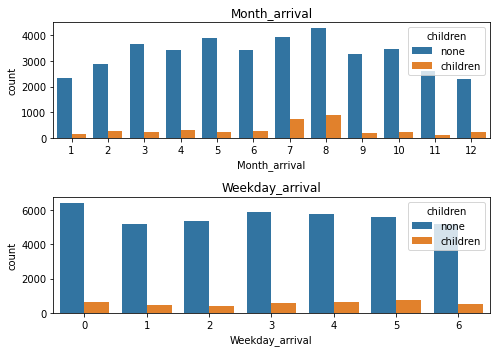

In [14]:
multiple_countplots(7, 5, hotels_copy, time_cols, 'children')

* Majority of people arrive to the hotels in July and August
* Across weekdays there doesn't seem to be a difference between them
* There seems to be a slight difference between the distributions for guests with and without children for the month arrival

To finalize, let's put some numbers on the general tendencies observed graphically.

In [15]:
for i in cat_cols_to_plot + time_cols:
  print(hotels_copy[i].value_counts()/hotels_copy.shape[0])

City_Hotel      0.59267
Resort_Hotel    0.40733
Name: hotel, dtype: float64
TA/TO        0.754039
Direct       0.173631
Corporate    0.069955
GDS          0.002351
Undefined    0.000023
Name: distribution_channel, dtype: float64
Online_TA        0.521286
Offline_TA/TO    0.189536
Direct           0.157174
Groups           0.061911
Corporate        0.057762
Complementary    0.009542
Aviation         0.002789
Name: market_segment, dtype: float64
A    0.666382
D    0.189351
E    0.068572
F    0.029457
G    0.020583
B    0.010626
C    0.009589
H    0.005394
L    0.000046
Name: reserved_room_type, dtype: float64
A    0.511605
D    0.266567
E    0.086067
F    0.041466
C    0.028189
G    0.027037
B    0.022243
H    0.007191
I    0.005463
K    0.004172
Name: assigned_room_type, dtype: float64
BB           0.783935
HB           0.107802
SC           0.097269
Undefined    0.007007
FB           0.003988
Name: meal, dtype: float64
0    0.951504
1    0.048496
Name: is_repeated_guest, dtype: float64

**Numerical features**

Now, I'll plot the numerical features to extract more insights.

In [16]:
num_cols_to_plot=['lead_time', 'adults','stays_in_weekend_nights', 'stays_in_week_nights','previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'average_daily_rate',
       'required_car_parking_spaces', 'total_of_special_requests', 'children']

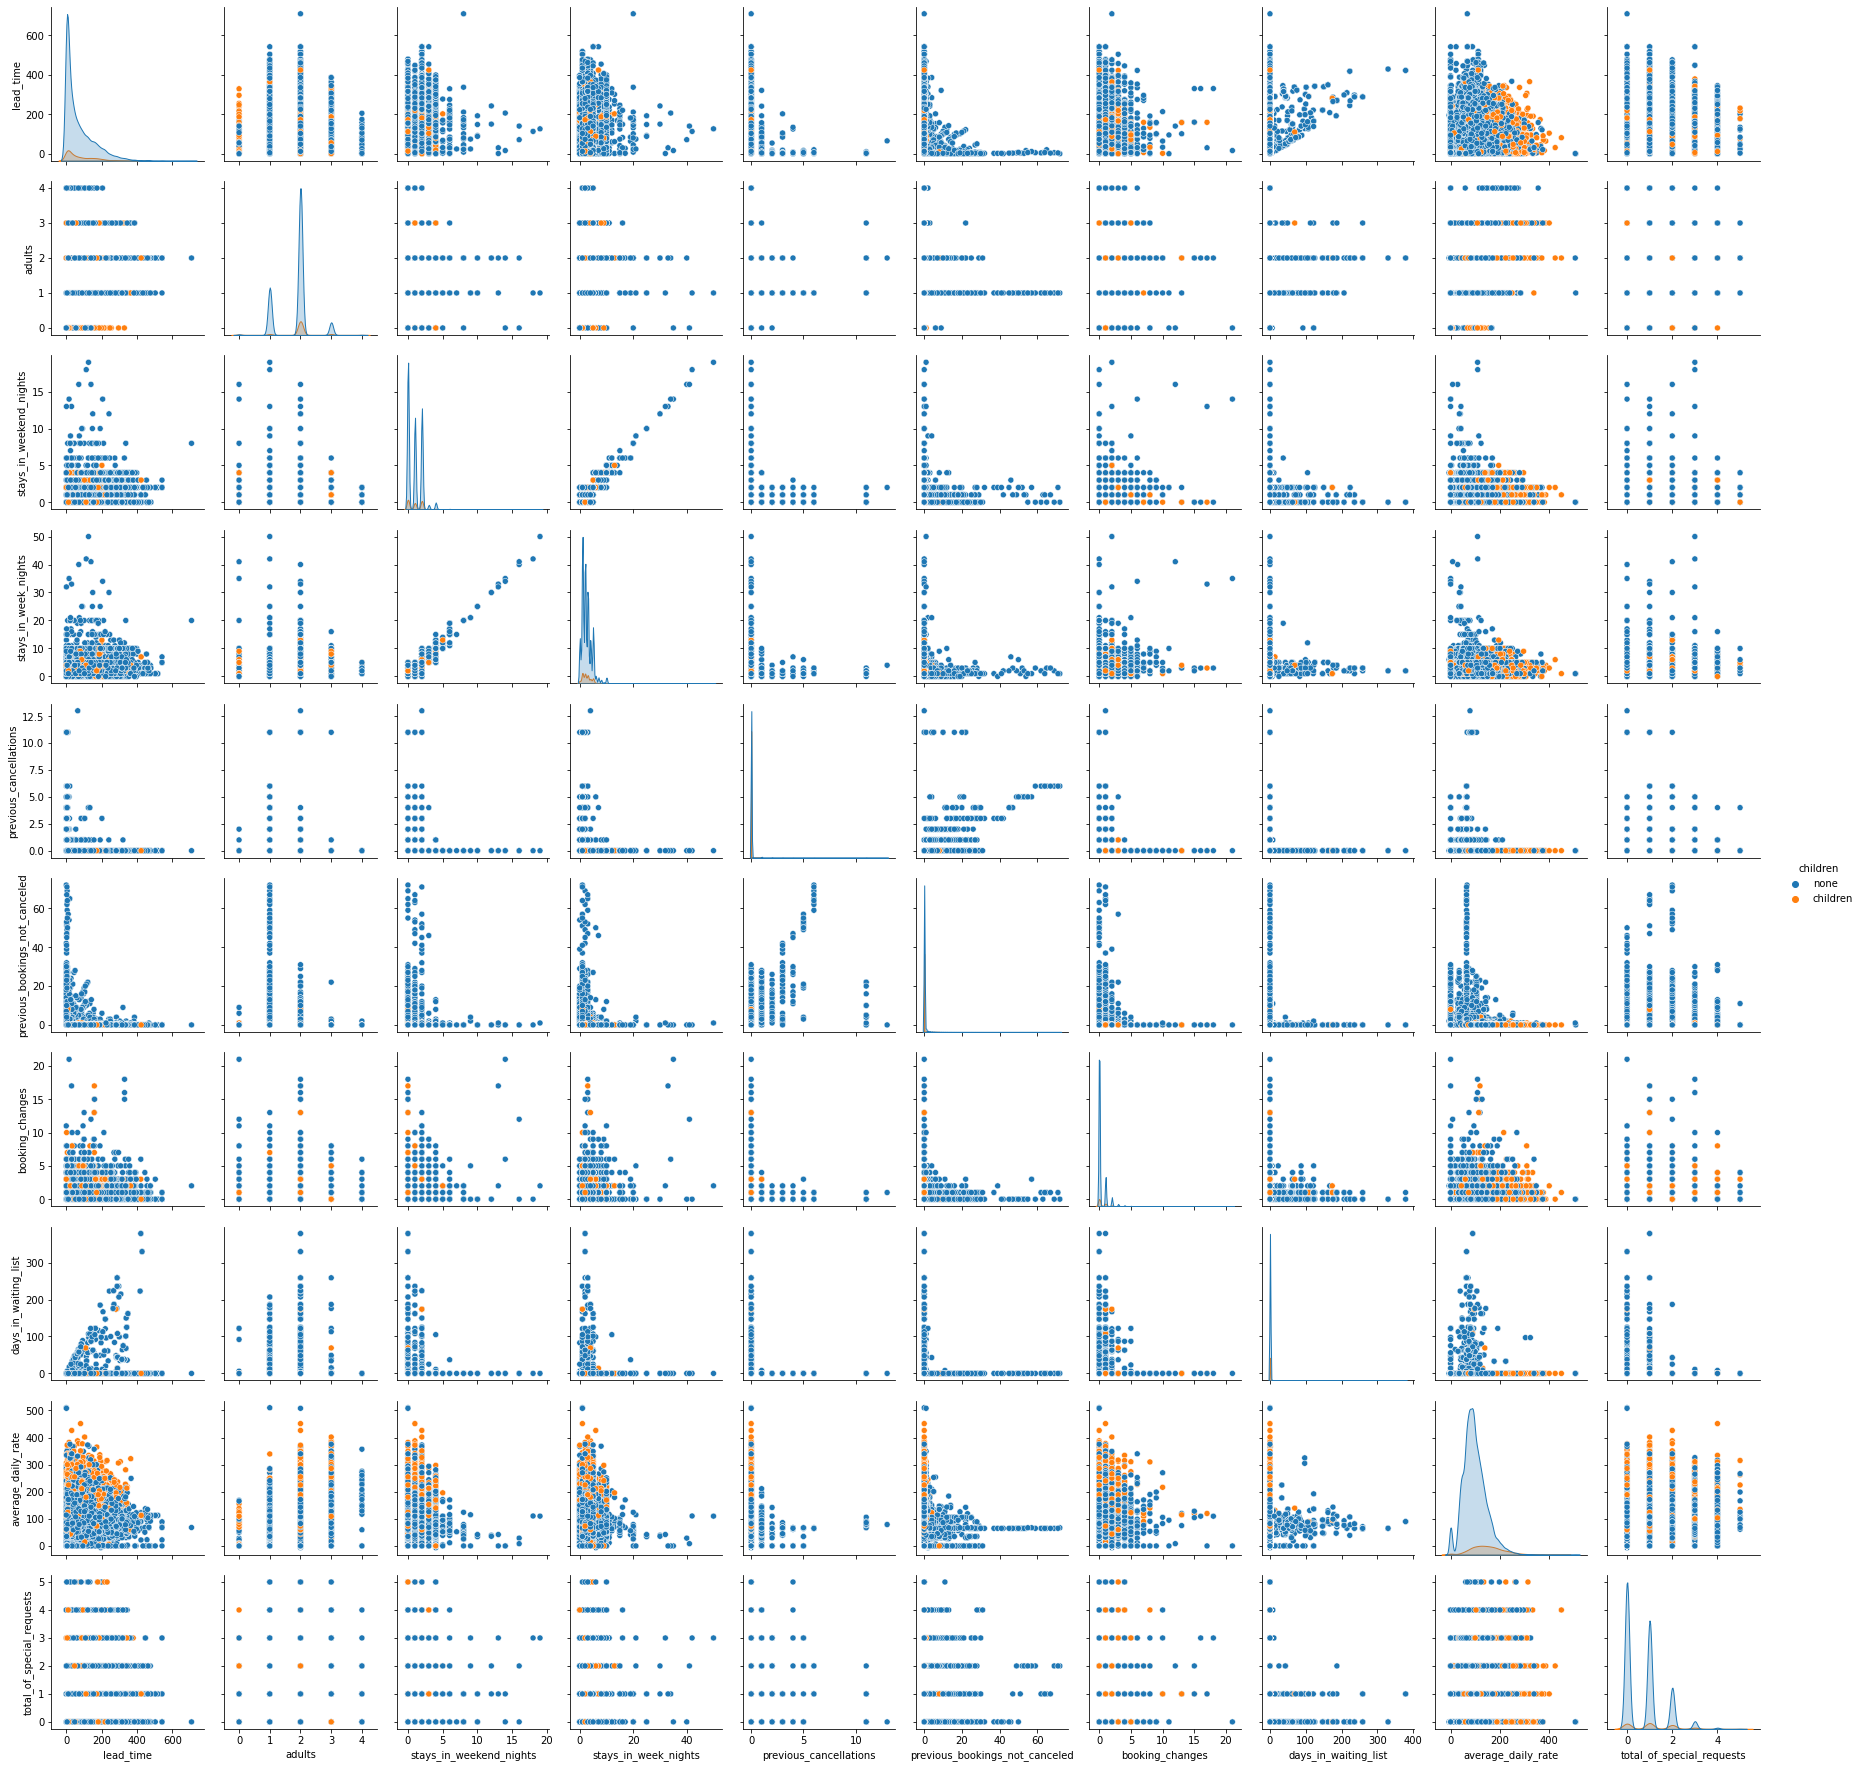

In [17]:
sns.pairplot(data=hotels_copy[num_cols_to_plot], hue= 'children')

* People with children tend to spend more money per day on average(average_daily_rate)
* Some distributions are skewed to the right (previous_cancellations, previous_bookings_not_canceled, days_in_waiting_list, booking changes, lead_time and stays_in_week_nights)
* Almost all the reservations with children had 2 adults
* Reservation with children tend to have 2 or less special requests.

In [18]:
hotels_copy[hotels_copy['children']=='children']['average_daily_rate'].mean()/hotels_copy[hotels_copy['children']=='none']['average_daily_rate'].mean()

1.5328065322912736

Like it was suspected from the graph, on average, people with children spend 50% more per day than people without them.

**Target distribution**

Text(0.5, 1.0, 'Target distribution')

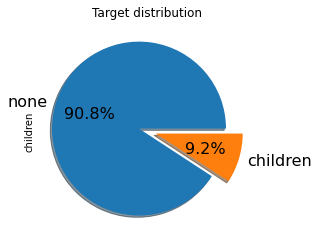

In [19]:
plt.figure(figsize=(4,4))
hotels_copy['children'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

In [20]:
hotels_copy['children'].value_counts()

none        39386
children     3999
Name: children, dtype: int64

Like I mentioned before, the dataset is imbalanced. I'll have to perform a sampling technique before ingesting this data into the model, otherwise it'll lead to wrong predictions. 

## Part II - Modeling

Build the best model to predict which actual hotel stays included children/babies, and which did not:

### **Feature engineering**

**Column selection**

Based on the EDA, I'll drop some columns that don't seem to contribute to the prediction on whereas a guest has children or not (they seem to have a similar distribution for both families with and without children)

In [21]:
columns_to_drop=['country', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'arrival_date', 'Weekday_arrival'] 

In [22]:
#Create a copy of the EDA dataset
hotels_selected_cols=hotels_copy.copy()

In [23]:
#Drop columns listed above
hotels_selected_cols=hotels_selected_cols.drop(columns= columns_to_drop, axis=1)

**Encoding of categorical variables**

In [24]:
hotels_selected_cols_enc=pd.get_dummies(hotels_selected_cols, drop_first=True)

In [25]:
hotels_selected_cols_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43385 entries, 0 to 43384
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   lead_time                            43385 non-null  int64  
 1   stays_in_weekend_nights              43385 non-null  int64  
 2   stays_in_week_nights                 43385 non-null  int64  
 3   adults                               43385 non-null  int64  
 4   is_repeated_guest                    43385 non-null  int64  
 5   previous_cancellations               43385 non-null  int64  
 6   previous_bookings_not_canceled       43385 non-null  int64  
 7   booking_changes                      43385 non-null  int64  
 8   days_in_waiting_list                 43385 non-null  int64  
 9   average_daily_rate                   43385 non-null  float64
 10  total_of_special_requests            43385 non-null  int64  
 11  Month_arrival               

**Log transform**

To reduce the skew observed in the EDA of some numerical features, will transform them using logarithm function. Most machine learning models work best when features follow a normal-like distribution.

In [26]:
#Create list with skewed features
skew_features=['previous_cancellations', 'previous_bookings_not_canceled', 'days_in_waiting_list', 'booking_changes', 'lead_time', 'stays_in_week_nights']

In [27]:
#Check the skew before the log transform
hotels_selected_cols_enc[skew_features].skew()

previous_cancellations            26.933607
previous_bookings_not_canceled    18.275962
days_in_waiting_list              17.604962
booking_changes                    5.349344
lead_time                          1.524624
stays_in_week_nights               2.948091
dtype: float64

In [28]:
#Define function to apply
def log_transform(col):
  return np.log(1+ col)

In [29]:
#Safety copy
hotels_log_transf=hotels_selected_cols_enc.copy()

In [30]:
#Apply function
hotels_log_transf[skew_features]= hotels_log_transf[skew_features].apply(log_transform)

In [31]:
hotels_log_transf[skew_features].skew()

previous_cancellations            14.982202
previous_bookings_not_canceled     6.119974
days_in_waiting_list              10.618700
booking_changes                    2.015992
lead_time                         -0.535359
stays_in_week_nights              -0.136502
dtype: float64

**Feature scaling**

I'll scale the numerical features in the dataset, this is a requirement for ML models to work properly.

Before performing the feature scaling, I'll separate the dataset into train and test to avoid data leakage. 

Data leakage occurs when information that would not be available at prediction time is used when building the model. This results in overly optimistic performance estimates, and thus poorer performance when the model is used on actually novel data.

Although both train and test data subsets should receive the same preprocessing transformation, it is important that these transformations are only learnt from the training data.

*Train-test split*

In [32]:
#Rename datasets
X=hotels_log_transf.drop(columns= 'children_none', axis=1)
y=hotels_log_transf['children_none']

In [33]:
#Split dataset into train and test
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=21, stratify= y)

In [34]:
#Reset index to avoid any confusion in future steps
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace= True, drop= True)
y_test.reset_index(inplace= True, drop= True)

*Scaling*

In [35]:
#Select columns to be scaled
scale_cols=['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'adults', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'average_daily_rate',
       'total_of_special_requests']

In [36]:
#Initialize RobustScaler
robscl= RobustScaler()

Fit and transform train dataset

In [37]:
#Scale train features
scaled_df=robscl.fit_transform(X_train[scale_cols])
#Convert into dataframe the scaled variables
scaled_features=pd.DataFrame(scaled_df, columns= ['scaled_lead_time', 'scaled_stays_in_weekend_nights', 'scaled_stays_in_week_nights',
       'scaled_adults', 'scaled_is_repeated_guest', 'scaled_previous_cancellations',
       'scaled_previous_bookings_not_canceled', 'scaled_booking_changes',
       'scaled_days_in_waiting_list', 'scaled_average_daily_rate',
       'scaled_total_of_special_requests'])

In [38]:
#Drop the original numerical columns (the ones before the scaling) and add the scaled ones
X_train_scaled=X_train.drop(columns= scale_cols, axis=1).merge(right=scaled_features, how= 'left', left_index= True, right_index=True)

Transform test dataset with the parameters obtained with the train dataset

In [39]:
#Transform the test dataset (X_test)
scaled_df_test=robscl.transform(X_test[scale_cols])
#Convert into dataframe the scaled variables
scaled_features_test=pd.DataFrame(scaled_df_test, columns= ['scaled_lead_time', 'scaled_stays_in_weekend_nights', 'scaled_stays_in_week_nights',
       'scaled_adults', 'scaled_is_repeated_guest', 'scaled_previous_cancellations',
       'scaled_previous_bookings_not_canceled', 'scaled_booking_changes',
       'scaled_days_in_waiting_list', 'scaled_average_daily_rate',
       'scaled_total_of_special_requests'])

In [40]:
#Drop the original numerical columns (the ones before the scaling) and add the scaled ones
X_test_scaled=X_test.drop(columns= scale_cols, axis=1).merge(right=scaled_features_test, how= 'left', left_index= True, right_index=True)

### **Model**

**Undersampling**

Like I've observed during the EDA, the dataset is imbalanced. Leaving the dataset like this will lead to inaccurate results since the models will be biased in their predictions towards the majority class.

To solve this issue there are some techniques that can be applied. In this notebook I'll undersample the majority class to be comparable with the number of records of the minority class. In this case, the minority class has a few thousands of records which is still an acceptable number of records to build a model with. Therefore, even though I'll loose data, I still have enough datapoints for the model.

In [41]:
#Concatenate training data back together
X = pd.concat([X_train_scaled, y_train], axis=1)

In [42]:
#Separate minority and majority classes
children = X[X['children_none']==0]
no_children = X[X['children_none']==1]

In [43]:
#Undersample majority class
no_children_undersample = resample(no_children,replace = False, n_samples = len(children), random_state = 21) 

In [44]:
#Combine minority data and undersampled majority class
undersample_train = pd.concat([no_children_undersample, children])

In [45]:
#Check
undersample_train['children_none'].value_counts()

1    2799
0    2799
Name: children_none, dtype: int64

In [46]:
#Split again into train features and target
X_train_under=undersample_train.drop(columns= 'children_none', axis=1).reset_index(drop=True)
y_train_under=undersample_train['children_none'].reset_index(drop=True)

**Machine Learning model**

I'll start with a Decision Tree Classifier. It's a simple model, but it can be a good one for a lot of cases. 

Decision Tree Classifier

In [47]:
tree=DecisionTreeClassifier()

In [48]:
#Fit the model to the training data
tree_model=tree.fit(X_train_under, y_train_under)

In [49]:
#Predict values for the test data
pred_test_y=tree.predict(X_test_scaled)

Model evaluation

To measure the performance of the model, I'll use F1 score (accuracy is not the best metric to use in imbalance dataset as it can be misleading) and the confusion matrix.

In [50]:
#Evaluate model with F1 score
test_f1_score=round(f1_score(y_test, pred_test_y),3)
test_f1_score

0.815

In [51]:
#Create confusion matrix
conf_matrix=confusion_matrix(y_test, pred_test_y)
conf_matrix_df= pd.DataFrame(conf_matrix)

Text(24.0, 0.5, 'True Label')

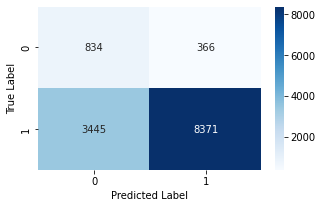

In [52]:
#Plot confusion matrix
fig=plt.figure(figsize= (5, 3))
sns.heatmap(conf_matrix_df, annot= True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

Note: 
* Label **0** means guests **with** children

* Label **1** means guests **without** children

In [53]:
#Check the tree depth - important feature to avoid overfitting.
print(tree.tree_.max_depth)

27


In [54]:
#Plot the decision tree
#plt.figure(figsize=(25,20))
#t = plot_tree(tree, 
#              feature_names=X.columns, 
#              class_names= 'children_none', 
#              filled=True, 
#              rounded=True, 
#              fontsize=14)

This first model shows a good F1 score of 0.812 and it predicts well the guests with children (true positive values in the top left side of the matrix).

When I plotted the decision tree (it's commented for now because the plot needs improvement), I can see the first branch was creted with average spent per day. This is a key feature that the model used to classify.

**Next steps to improve the results**

* Try more classification models (like Random Forest, XGBoost or Logistic Regression)
* Tune hyperparameters
* Add one of the dropped columns (maybe the country column could be added in a different way to avoid having a huge dataset)